Analyse some recent GOLEM shots from 2500 to 26852. 

# Getting data

The dataset has been created from the [GolSQL tool](http://golem.fjfi.cvut.cz/utils/miner), with the follow URL used to generate the dataset:


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
dataset = pd.read_csv('close_shots_big.txt', delimiter='\s+', index_col='shots')

In [3]:
dataset.head()

,pressure_initial,cbd,cb,breakdown_field,tb,electron_temperature_max,ucd,tcd,breakdown_voltage,plasma_life,...,tbd,breakdown_rate_err,ubd,breakdown_probability,discharge_aborted,pressure_chamber,loop_voltage_mean,ccd,loop_voltage_max,ub
shots,,,,,,,,,,,,,,,,,,,,,
10000,1.24,0.0036,0.081,0.13007,0.005,24.347,400.0,0.007,8.4863,0.01086,...,0.008,7.582200e-06,0.0,92.0,NaN,NaN,7.6135,0.01125,12.7130,1000.0
10001,1.26,0.0036,0.081,0.40670,0.005,22.729,600.0,0.015,10.8430,0.00998,...,0.005,2.165000e-06,0.0,97.0,NaN,NaN,11.9370,0.01125,17.7620,1000.0
10002,1.28,0.0036,0.081,0.16900,0.005,31.894,600.0,0.015,10.4000,0.01028,...,0.005,NaN,0.0,NaN,NaN,NaN,10.2190,0.01125,25.2860,500.0
10003,1.29,0.0036,0.081,0.36822,0.005,18.414,300.0,0.015,7.3181,0.00998,...,0.005,1.240500e-05,0.0,63.0,NaN,NaN,6.1298,0.01125,7.9627,1000.0
10004,1.23,0.0036,0.081,0.12174,0.005,31.671,600.0,0.015,10.5680,0.00906,...,0.005,7.685700e-07,0.0,97.0,NaN,NaN,9.8761,0.01125,28.3800,300.0


# Cleaning data

Filter bad shots from the dataset, as adviced in the [GOLEM DataMining Page](http://golem.fjfi.cvut.cz/wiki/Handling/DataMining/data_mining)

In [4]:
print(len(dataset)) # number of shot before cleaning 

15977


In [5]:
# Drop failed plasma
dataset = dataset.dropna(subset=['plasma'])

# Drop plasma longer than 25 ms
dataset = dataset.drop(dataset[dataset['plasma_life'] > 25e-3].index)

# Drop loop voltage below than 5V
dataset = dataset.drop(dataset[dataset['loop_voltage_max'] < 5].index)

# Drop pressure larger than 100mPa
dataset = dataset.drop(dataset[dataset['pressure'] > 100].index)

# number of shot after cleaning
print(len(dataset)) 

14282


# Which parameters to improve the plasma lifetime?

In [6]:
# get the longest shots
dataset.sort_values('plasma_life', ascending=False).head()

,pressure_initial,cbd,cb,breakdown_field,tb,electron_temperature_max,ucd,tcd,breakdown_voltage,plasma_life,...,tbd,breakdown_rate_err,ubd,breakdown_probability,discharge_aborted,pressure_chamber,loop_voltage_mean,ccd,loop_voltage_max,ub
shots,,,,,,,,,,,,,,,,,,,,,
25341,0.19639,0.0036,0.0675,0.068972,0.005,NaN,400.0,0.005,8.8824,0.02498,...,0.005,NaN,0.0,89.0,NaN,NaN,4.5386,0.01350,8.2084,1300.0
23800,0.13277,0.0036,0.0675,0.061511,0.005,NaN,400.0,0.005,8.4863,0.02498,...,0.005,NaN,0.0,89.0,NaN,NaN,4.2969,0.01350,7.9022,1300.0
25483,0.56435,0.0036,0.0675,0.068445,0.005,NaN,400.0,0.005,9.2651,0.02494,...,0.005,NaN,0.0,90.0,NaN,NaN,4.5117,0.01350,8.7884,1300.0
24292,0.22723,0.0036,0.0675,0.070704,0.005,84.685,450.0,0.005,9.9164,0.02494,...,0.005,NaN,0.0,93.0,NaN,NaN,4.6930,0.01350,9.5740,1300.0
12791,2.70200,0.0036,0.0810,0.078577,0.005,NaN,600.0,0.007,17.4630,0.02490,...,0.005,0.000002,0.0,10.0,NaN,NaN,2.0293,0.01125,17.8300,1000.0


According to the GOLEM documentation, the following parameters can be tuned for each plasma shot:

 - Toroidal Magnetic Field, set by $U_B$
 - Current Drive, set bu $U_{CD}$
 - Time delay for Current Drive, $\tau_{CD}$
 - Filling Pressure, $p_{WG}$ [mPa]
 
So let's look for the set of parameters which maximize the plasma duration

In [7]:
reduced_set = dataset[['ub', 'ucd', 'tcd', 'pressure_request','plasma_life', 'electron_temperature_max']]
reduced_set.sort_values('plasma_life', ascending=False).head()

,ub,ucd,tcd,pressure_request,plasma_life,electron_temperature_max
shots,,,,,,
25341,1300.0,400.0,0.005,20.0,0.02498,NaN
23800,1300.0,400.0,0.005,20.0,0.02498,NaN
25483,1300.0,400.0,0.005,20.0,0.02494,NaN
24292,1300.0,450.0,0.005,20.0,0.02494,84.685
12791,1000.0,600.0,0.007,8.0,0.02490,NaN


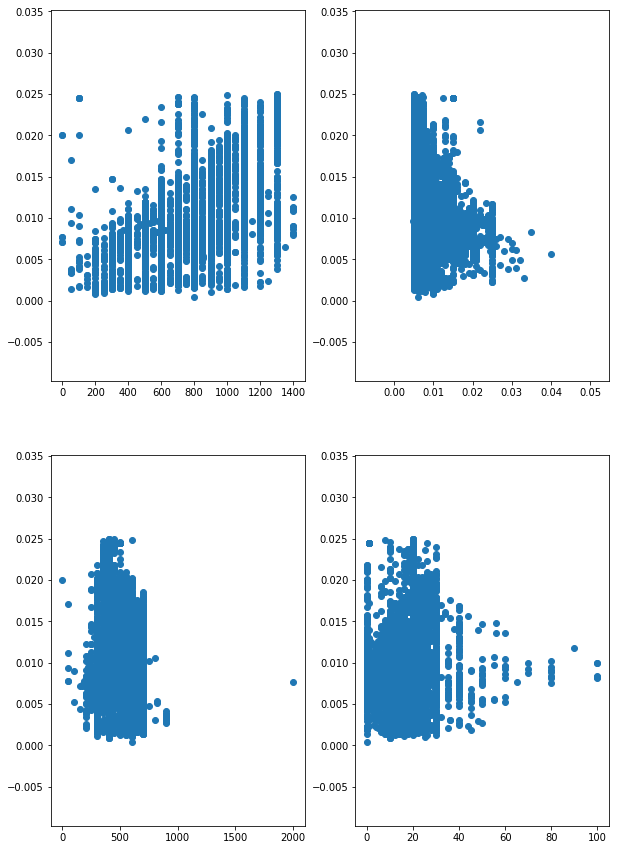

In [8]:
fig, ax = plt.subplots(2, 2, figsize=(10,15))
ax[0,0].scatter(reduced_set['ub'], reduced_set['plasma_life'])
ax[1,0].scatter(reduced_set['ucd'], reduced_set['plasma_life'])
ax[0,1].scatter(reduced_set['tcd'], reduced_set['plasma_life'])
ax[1,1].scatter(reduced_set['pressure_request'], reduced_set['plasma_life'])

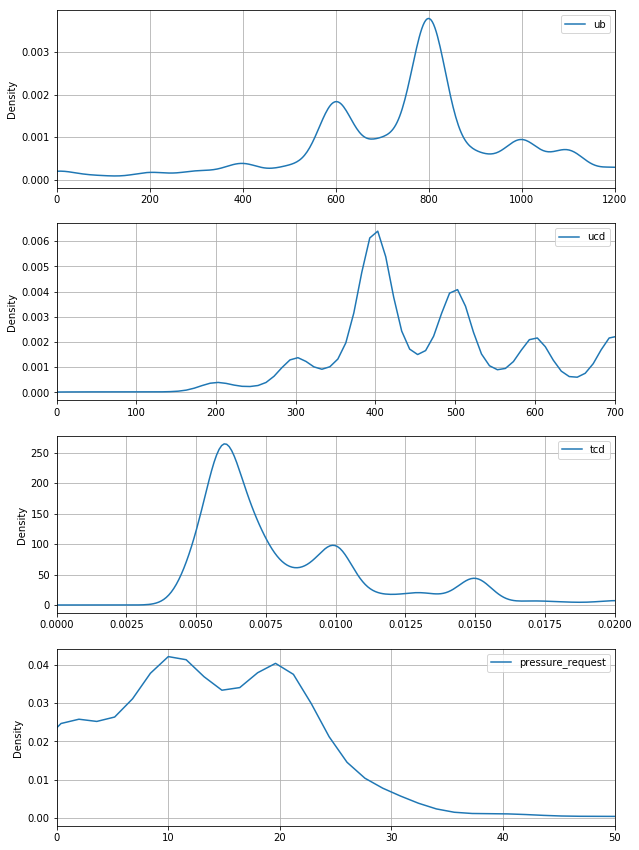

In [33]:
fig, ax = plt.subplots(4, 1,figsize=(10,15))
reduced_set.plot(x='plasma_life', y='ub', kind='density', grid=True, ax=ax[0], xlim=(0,1200))
reduced_set.plot(x='plasma_life', y='ucd', kind='density', grid=True, ax=ax[1], xlim=(0,700))
reduced_set.plot(x='plasma_life', y='tcd', kind='density', grid=True, ax=ax[2], xlim=(0,0.02))
reduced_set.plot(x='plasma_life', y='pressure_request', kind='density', grid=True, ax=ax[3], xlim=(0,50))

The question is : what is the set of parameters $\{u_B, u_{CD}, \tau_{CD}, p\}$ which maximize the plasma duration. 

to look http://scikit-learn.org/stable/tutorial/statistical_inference/supervised_learning.html